In [66]:
import tensorflow as tf
from keras import layers,models,optimizers
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import precision_score,recall_score, f1_score
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
import os

In [10]:
classes = ["altar","bell_tower","column","dome(outer)","gargoyle","stained_glass","vault"]
zip_path = "/content/drive/MyDrive/Datasets/architectural.zip"
dataset_path = "/content/architectural/Architectural_Heritage_Elements_Dataset_128(creative_commons)"
weights_path = "/content/drive/MyDrive/checkpoints/"

In [11]:
with ZipFile(zip_path, 'r') as zip: 
    zip.extractall('/content/architectural')

In [12]:
# Declaring limit of instances by set
max_i = {"train":500,"validation":200,"test":100}

# Declaring sets
sets = max_i.keys()

In [13]:
# Creating folders
for s in sets:
  temp_path = os.path.join(dataset_path,s)
  os.mkdir(temp_path)
  for c in classes:
    os.mkdir(os.path.join(temp_path,c))

# Moving files to folders
for c in classes:
  for s in sets:
    for f in os.listdir(os.path.join(dataset_path,c)):
      from_path = os.path.join(dataset_path,c,f)
      to_path = os.path.join(dataset_path,s,c,f)
      if (len(os.listdir(os.path.join(dataset_path,s,c))) < max_i[s]):
        os.rename(from_path,to_path)

In [46]:
#Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path,"train"),
        color_mode="rgb",
        batch_size=1,
        target_size=(224, 224),
        shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
        os.path.join(dataset_path,"validation"), 
        color_mode="rgb",
        batch_size=1,
        target_size=(224, 224),
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_path,"test"),
        color_mode="rgb",
        batch_size=1,
        target_size=(224, 224),
        shuffle=False) # FALSE

Found 3500 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [21]:
# Creating Callback to save model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/checkpoints/exa3/weights.h5",
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_acc', 
                                                 mode='max',
                                                 verbose=1)

In [22]:
# Trasfer Learning
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)) 

# Freezing important weights.
for layer in conv_base.layers:
    if layer.name[:6] == 'block5': 
      layer.trainable = True
    else:
      layer.trainable = False

# Defining model
model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))

# Compiling model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc']) #'acc' -> accuracy -> precisión

In [23]:
# Training model
history = model.fit(
      train_generator,
      steps_per_epoch=50, 
      epochs=500,
      validation_data=validation_generator,
      validation_steps=100,
      callbacks=[cp_callback])

Epoch 1/500
50/50 [==============================] - 3s 42ms/step - loss: 2.2033 - acc: 0.2594 - val_loss: 2.2088 - val_acc: 0.2400

Epoch 00001: val_acc improved from -inf to 0.24000, saving model to /content/drive/MyDrive/checkpoints/exa3/weights.h5
Epoch 2/500
50/50 [==============================] - 2s 37ms/step - loss: 1.6054 - acc: 0.5219 - val_loss: 1.6234 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.24000 to 0.40000, saving model to /content/drive/MyDrive/checkpoints/exa3/weights.h5
Epoch 3/500
50/50 [==============================] - 2s 37ms/step - loss: 1.0657 - acc: 0.6207 - val_loss: 1.3978 - val_acc: 0.5100

Epoch 00003: val_acc improved from 0.40000 to 0.51000, saving model to /content/drive/MyDrive/checkpoints/exa3/weights.h5
Epoch 4/500
50/50 [==============================] - 2s 37ms/step - loss: 0.9046 - acc: 0.7073 - val_loss: 2.0095 - val_acc: 0.4900

Epoch 00004: val_acc did not improve from 0.51000
Epoch 5/500
50/50 [==============================] - 2s

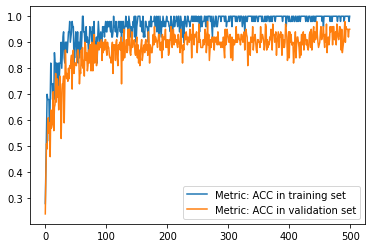

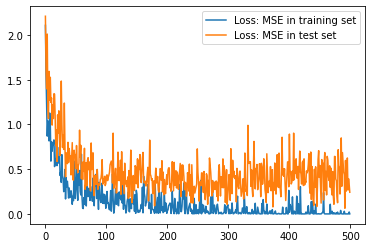

Best epoch:  267
ACC Validation Best Epoch: 0.9800000190734863
MSE Validation Best Epoch: 267


In [24]:
loss = history.history['loss']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1

# Plot history base on Metric 
plt.plot(history.history['acc'], label='Metric: ACC in training set')
plt.plot(history.history['val_acc'], label='Metric: ACC in validation set')
plt.legend()
plt.show()

# Plot history base on Loss
plt.plot(history.history['loss'], label='Loss: MSE in training set')
plt.plot(history.history['val_loss'], label='Loss: MSE in test set')
plt.legend()
plt.show()

print('Best epoch: ', max_val_acc_epoch)
print('ACC Validation Best Epoch:', max_val_acc)
print('MSE Validation Best Epoch:', max_val_acc_epoch)

In [63]:
# Confusion Matrix
y_test = test_generator.classes
y_pred = model.predict_generator(test_generator, steps=700)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [68]:
print("Confusion Matrix Metrics en el Conjunto de Prueba:\n",cm)
print('Precision: %.7f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Recall: %.7f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('F1: %.7f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

[[98  0  1  0  0  0  1]
 [ 2 89  6  2  0  1  0]
 [ 0  2 95  0  2  0  1]
 [ 0 10  2 87  1  0  0]
 [ 1  6  2  1 90  0  0]
 [ 2  0  1  0  0 95  2]
 [ 1  0  1  1  0  0 97]]
Precision: 0.9324969
Recall: 0.9300000
F1: 0.9303355


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
